In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pathlib

In [2]:
def parse_data_yastn(fname):
    Ds, times, engs = [], [], []
    with open(fname, 'rt') as f:
        for line in f.readlines():
            if not line.startswith("Sweep"):
                continue
            tmp = line.split(";")
            eng = float(tmp[1].split("=")[1].strip())
            D = int(tmp[2].split("=")[1].strip())
            time = float(tmp[3].split("=")[1].strip())
            if D < 32:
                D_current, time_current, eng_current = D, [], []
            elif D != D_current:  # ignore line where D is changing
                if D_current >= 32:
                    engs.append(np.mean(eng_current))
                    times.append(np.mean(time_current))
                    Ds.append(D_current)
                D_current, time_current, eng_current = D, [], []
            else:
                eng_current.append(eng)
                time_current.append(time)
        engs.append(np.mean(eng_current))
        times.append(np.mean(time_current))
        Ds.append(D_current)
    return Ds, times, engs

In [3]:
def parse_data_itensor(fname):
    Ds, times, engs = [], [], []
    with open(fname, 'rt') as f:
        for line in f.readlines():
            if not line.startswith("After"):
                continue
            tmp = line.split(" ")
            eng = float(tmp[3].split("=")[1].strip())
            D = int(tmp[5].split("=")[1].strip())
            time = float(tmp[7].split("=")[1].strip())
            if D < 32:
                D_current, time_current, eng_current = D, [], []
            elif D != D_current:  # ignore line where D is changing
                if D_current >= 32:
                    engs.append(np.mean(eng_current))
                    times.append(np.mean(time_current))
                    Ds.append(D_current)
                D_current, time_current, eng_current = D, [], []
            else:
                eng_current.append(eng)
                time_current.append(time)
        engs.append(np.mean(eng_current))
        times.append(np.mean(time_current))
        Ds.append(D_current)
    return Ds, times, engs

In [4]:
def parse_data_tenpy(fname):
    Ds, times, engs = [], [], []
    with open(fname, 'rt') as f:
        line = f.readline()
        while line:
            if not line.startswith("energy="):
                line = f.readline()
                continue
            tmp = line.split(",")
            eng = float(tmp[0].split("=")[1].strip())
            line = f.readline()
            tmp = line.split(":")[1]
            time = float(tmp.strip().replace("s", ""))
            line = f.readline()
            line = f.readline()
            line = f.readline()
            tmp = line.split(":")[1]
            D = int(tmp.strip())
            if D < 32:
                D_current, time_current, eng_current = D, [], []
            elif D != D_current:  # ignore line where D is changing
                if D_current >= 32:
                    engs.append(np.mean(eng_current))
                    times.append(np.mean(time_current))
                    Ds.append(D_current)
                D_current, time_current, eng_current = D, [], []
            else:
                eng_current.append(eng)
                time_current.append(time)
            line = f.readline()
        engs.append(np.mean(eng_current))
        times.append(np.mean(time_current))
        Ds.append(D_current)
    return Ds, times, engs

In [ ]:
glob_path = os.path.join(os.path.abspath(""), "i9_10920/*.txt")

In [21]:
glob_path

'/home/marek/benchmarks/results_dmrg/i9_10920\\*.txt'

In [19]:
for x in glob.glob(glob_path):
    print(x)

In [16]:
import os
os.path.abspath("")

'/home/marek/benchmarks/results_dmrg'

In [14]:
pathlib.Path(__file__).parent.resolve()

NameError: name '__file__' is not defined

In [6]:
data_yastn = {}
for fname in glob.glob(glob_path):
    if "yastn_U1" in fname:
        Ds, times, engs = parse_data_yastn(fname)
        ind = fname.split("_U1_")[1].replace(".txt", "")
        data_yastn[ind] = {"Ds": Ds, "times": times, "engs": engs}

In [7]:
data_itensor = {}
for fname in glob.glob(glob_path):
    if "itensor_U1" in fname:
        Ds, times, engs = parse_data_itensor(fname)
        ind = fname.split("_U1_")[1].replace(".txt", "")
        data_itensor[ind] = {"Ds": Ds, "times": times, "engs": engs}

In [8]:
data_tenpy = {}
for fname in glob.glob(glob_path):
    if "tenpy_cons_Sz" in fname:
        Ds, times, engs = parse_data_tenpy(fname)
        ind = fname.split("_False_")[1].replace(".txt", "")
        data_tenpy[ind] = {"Ds": Ds, "times": times, "engs": engs}

In [9]:
e0 = np.min(data_itensor["cpu1"]["engs"])

for ind, vals in data_yastn.items():
    plt.loglog(vals["Ds"], [abs(x -e0) for x in vals["engs"]], 'x', label=ind)
for ind, vals in data_itensor.items():
    plt.loglog(vals["Ds"],  [abs(x -e0) for x in vals["engs"]], '+', label=ind)
for ind, vals in data_tenpy.items():
    plt.loglog(vals["Ds"],  [abs(x -e0) for x in vals["engs"]], 'o', label=ind)

plt.xlabel("bond dimension D")
plt.ylabel("energy - energy_0")
plt.ylim([1e-11, 1e-3])
plt.legend()


KeyError: 'cpu1'

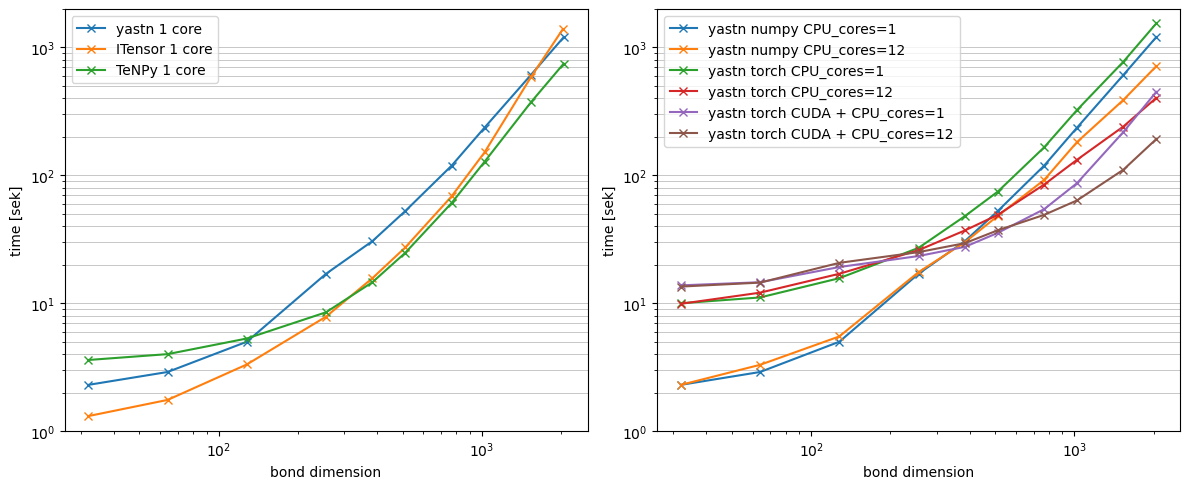

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#
vals = data_yastn["np126_cpu1"]
ax[0].loglog(vals["Ds"], vals["times"], 'x-', label="yastn 1 core")
vals = data_itensor["cpu1"]
ax[0].loglog(vals["Ds"], vals["times"], 'x-', label="ITensor 1 core")
vals = data_tenpy["cpu1"]
ax[0].loglog(vals["Ds"], vals["times"], 'x-', label="TeNPy 1 core")

ax[0].set_xlabel("bond dimension")
ax[0].set_ylabel("time [sek]")
ax[0].legend()
ax[0].grid(visible=True, which='both', axis='y', linewidth=0.5)
ax[0].set_ylim([1, 2000])
#
#
labels = {"np126_cpu1": "yastn numpy CPU_cores=1",
          "np126_cpu12": "yastn numpy CPU_cores=12",
          "torch24_cpu1": "yastn torch CPU_cores=1",
          "torch24_cpu12": "yastn torch CPU_cores=12",
          "torch24_cuda_cpu1": "yastn torch CUDA + CPU_cores=1",
          "torch24_cuda_cpu12": "yastn torch CUDA + CPU_cores=12"}

for ind, label in labels.items():
    vals = data_yastn[ind]
    ax[1].loglog(vals["Ds"], vals["times"], 'x-', label=label)

ax[1].set_xlabel("bond dimension")
ax[1].set_ylabel("time [sek]")
ax[1].legend()
ax[1].grid(visible=True, which='both', axis='y', linewidth=0.5)
ax[1].set_ylim([1, 2000])

fig.tight_layout()